<a href="https://colab.research.google.com/github/rybak97/free_courses/blob/main/Recurrent_Neural_Network_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on: https://www.datacamp.com/tutorial/tutorial-for-recurrent-neural-network

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(43)
np.random.seed(43)

In [2]:
url = 'https://raw.githubusercontent.com/siddhartha-malepalle/Mastercard-Stock-Price-Analysis-Forecasting/refs/heads/main/Mastercard_data/Mastercard_stock_history.csv'
df = pd.read_csv(url, index_col="Date", parse_dates=["Date"])
df = df.drop(columns=["Dividends", "Stock Splits"])
df.index = df.index.astype(str).str.split(' ').str[0]

display(df.head())

,Open,High,Low,Close,Volume
Date,,,,,
2006-05-25,3.677800,4.202548,3.668674,4.197985,395343000
2006-05-26,4.225363,4.265517,4.025502,4.100336,103044000
2006-05-30,4.103990,4.104902,3.910517,4.015467,49898000
2006-05-31,4.047406,4.139579,4.047406,4.101250,30002000
2006-06-01,4.100334,4.389630,4.097596,4.335786,62344000


In [3]:
df.describe()

,Open,High,Low,Close,Volume
count,4733.000000,4733.000000,4733.000000,4733.000000,4.733000e+03
mean,157.218445,158.751430,155.650434,157.248719,1.062101e+07
std,151.827873,153.182400,150.433224,151.846666,1.632991e+07
min,3.677800,4.024589,3.668674,4.006337,6.411000e+05
25%,24.703870,25.007020,24.386382,24.721483,3.020000e+06
50%,87.602214,88.402167,86.976627,87.724739,4.742400e+06
75%,298.458871,302.054722,294.400031,298.368073,1.062100e+07
max,577.330017,582.229980,570.000000,576.309998,3.953430e+08


In [4]:
df.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0


In [5]:
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2025-03-12,530.510010,532.710022,519.260010,524.640015,2810800
2025-03-13,524.500000,528.530029,517.710022,519.830017,2375800
2025-03-14,522.599976,528.409973,520.950012,527.640015,2369500
2025-03-17,523.250000,533.479980,521.479980,531.989990,2544800
2025-03-18,532.340027,532.590027,525.510010,528.354980,901928


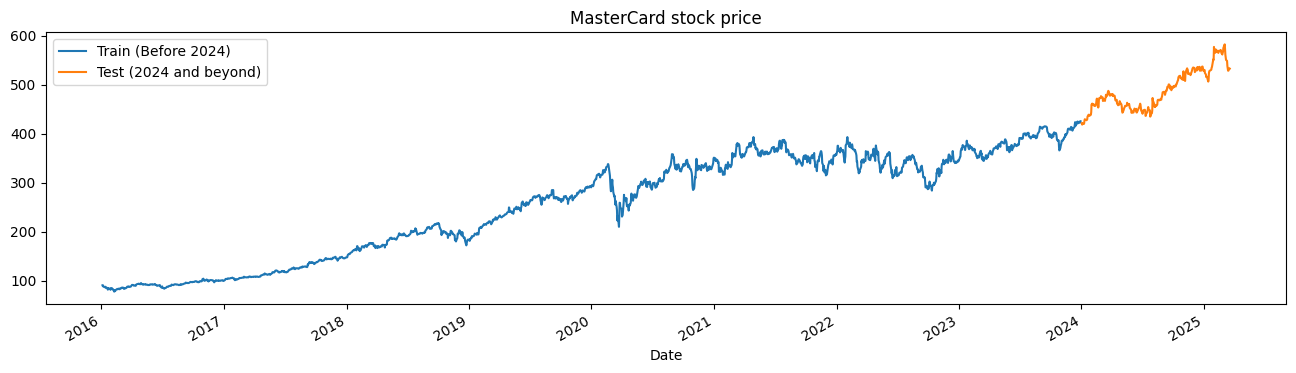

In [6]:
df.index = pd.to_datetime(df.index)
tstart = 2016
tend = 2023

def train_test_plot(df, tstart, tend):
    df.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    df.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(df,tstart,tend)

In [7]:
def train_test_split(df, tstart, tend):
    train = df.loc[f"{tstart}":f"{tend}", "High"].values
    test = df.loc[f"{tend+1}":, "High"].values
    return train, test
training_set, test_set = train_test_split(df, tstart, tend)

In [8]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

The split_sequence function uses a training dataset and converts it into inputs (X_train) and outputs (y_train).

For example, if the sequence is [1,2,3,4,5,6,7,8,9,10,11,12] and the n_step is three, then it will convert the sequence into three input timestamps and one output as shown below:

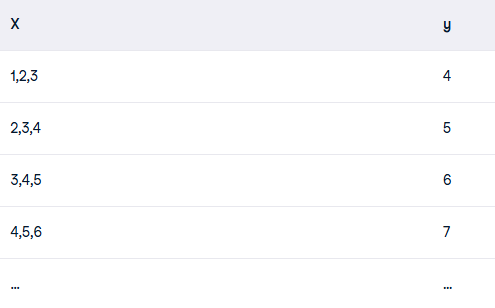

In [9]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [10]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

LSTM model

In [11]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=200, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 200)            │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,801 (632.04 KB)

 Trainable params: 161,801 (632.04 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model_lstm.fit(X_train, y_train, epochs=150, batch_size=64)

Epoch 1/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0632
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032
Epoch 3/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031
Epoch 4/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037
Epoch 5/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 6/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023
Epoch 7/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 8/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 9/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 10/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 11/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.1962e-04
Epoch 12/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 13/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.2449e-04
Epoch 14/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4703e-04
Epoch 15/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss

In [13]:
dataset_total = df.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [14]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

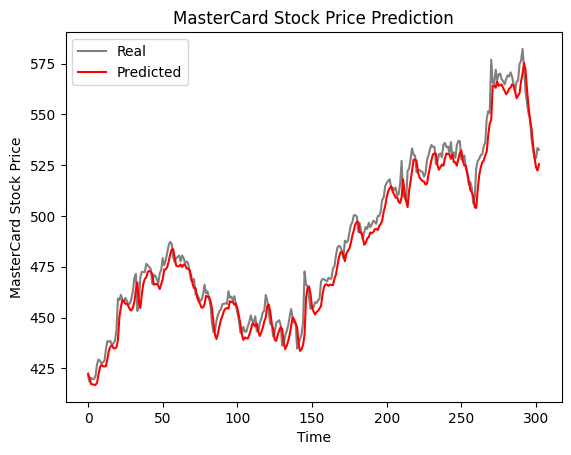

In [15]:
plot_predictions(test_set,predicted_stock_price)

In [16]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 6.71.


GRU model

In [17]:
model_gru = Sequential()
model_gru.add(GRU(units=200, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 200)            │       121,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,001 (476.57 KB)

 Trainable params: 122,001 (476.57 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model_gru.fit(X_train, y_train, epochs=150, batch_size=64)

Epoch 1/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0586
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028
Epoch 3/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028
Epoch 4/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 5/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 6/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011
Epoch 7/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 8/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.7031e-04
Epoch 9/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 10/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3700e-04
Epoch 11/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 12/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3182e-04
Epoch 13/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010
Epoch 14/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.1765e-04
Epoch 15/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - l

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


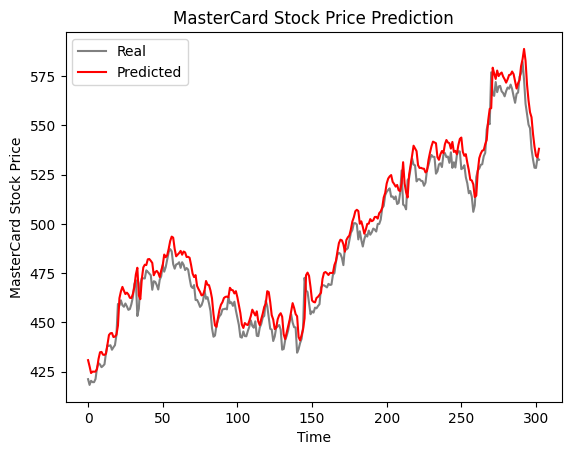

In [19]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

In [20]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 7.68.
